# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [2]:
student1 = "Guirec Maloisel"
student2 = "Adrian Valente"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
#np.random.seed(hash(student1 + student2) % 2**32)
#subset_of_classes = np.random.choice(range(10), 5, replace = False)
subset_of_classes = np.array([0,1,5,8,6])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
subset_of_classes

array([0, 1, 5, 8, 6])

### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

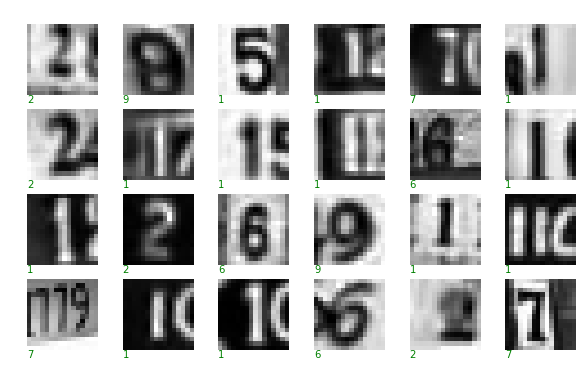

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Train on 40427 samples, validate on 14839 samples
Epoch 1/2000
40427/40427 [==============================] - 2s 55us/step - loss: 1.5522 - acc: 0.3192 - val_loss: 1.5422 - val_acc: 0.3414
Epoch 2/2000
40427/40427 [==============================] - 1s 30us/step - loss: 1.5372 - acc: 0.3356 - val_loss: 1.5302 - val_acc: 0.3537
Epoch 3/2000
40427/40427 [==============================] - 1s 32us/step - loss: 1.5284 - acc: 0.3433 - val_loss: 1.5215 - val_acc: 0.3511
Epoch 4/2000
40427/40427 [==============================] - 1s 32us/step - loss: 1.5218 - acc: 0.3474 - val_loss: 1.5153 - val_acc: 0.3539
Epoch 5/2000
40427/40427 [==============================] - 1s 33us/step - loss: 1.5171 - acc: 0.3504 - val_loss: 1.5114 - val_acc: 0.3529
Epoch 6/2000
40427/40427 [==============================] - 1s 31us/step - loss: 1.5134 - acc: 0.3536 - val_loss: 1.5082 - val_acc: 0.3570
Epoch 7/2000
40427/40427 [==============================] - 1s 30us/step - loss: 1.5106 - acc: 0.3549 - val_loss: 1.

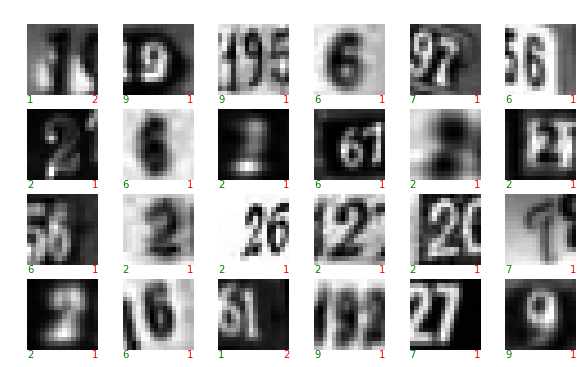

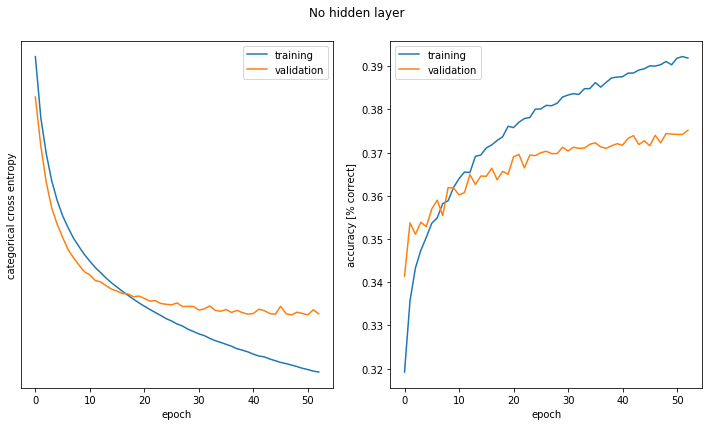

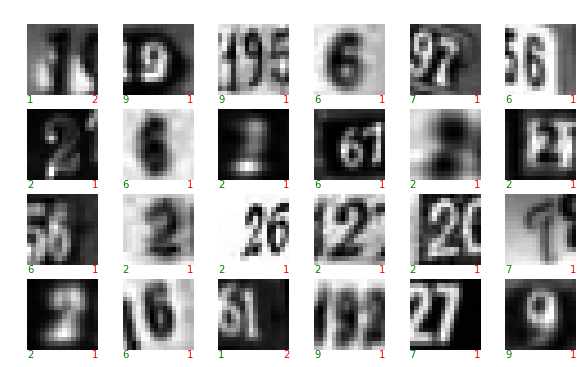

In [14]:
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(5, activation='softmax', input_shape=(256,)))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, 
          batch_size=128, epochs=2000, callbacks=[es], validation_data=(x_test, y_test),  verbose=1)
score = model.evaluate(x_test, y_test)
print(score)
plot_history(history, "No hidden layer")
yhat_test = model.predict(x_test)
error_indices = np.where(np.argmax(y_test, axis=1) != np.argmax(yhat_test, axis=1))[0]
plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping=subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

### Tests with SGD

In [15]:
lr = 0.001
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.summary()
model2.optimizer.lr = lr
model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40427/40427 [==============================] - 1s 28us/step - loss: 1.6131 - acc: 0.1553
Epoch 2/50
40427/40427 [==============================] - 1s 21us/step - loss: 1.5865 - acc: 0.2305
Epoch 3/50
40427/40427 [==============================] - 1s 22us/step - loss: 1.5712 - acc: 0.2871
Epoch 4/50
40427/40427 [==============================] - 1s 22us/step - loss: 1.5610 - acc: 0.3131
Epoch 5/50
40427/40427 [==============================] - 1s 22us/step - loss: 1.5537 - acc: 0.3250
Epoch 6/50
40427/40427 [==========

In [16]:
lr = 0.01
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.summary()
model2.optimizer.lr = lr
model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40427/40427 [==============================] - 1s 29us/step - loss: 1.5553 - acc: 0.3251
Epoch 2/50
40427/40427 [==============================] - 1s 24us/step - loss: 1.5314 - acc: 0.3433
Epoch 3/50
40427/40427 [==============================] - 1s 24us/step - loss: 1.5261 - acc: 0.3429: 1s - loss: 1.
Epoch 4/50
40427/40427 [==============================] - 1s 24us/step - loss: 1.5222 - acc: 0.3429
Epoch 5/50
40427/40427 [==============================] - 1s 24us/step - loss: 1.5192 - acc: 0.3429
Epoch 6/50
40427/40

In [17]:
lr = 0.05
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.summary()
model2.optimizer.lr = lr
model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40427/40427 [==============================] - 1s 30us/step - loss: 1.5281 - acc: 0.3393
Epoch 2/50
40427/40427 [==============================] - 1s 22us/step - loss: 1.5084 - acc: 0.3429
Epoch 3/50
40427/40427 [==============================] - 1s 23us/step - loss: 1.4958 - acc: 0.3429
Epoch 4/50
40427/40427 [==============================] - 1s 22us/step - loss: 1.4785 - acc: 0.3444
Epoch 5/50
40427/40427 [==============================] - 1s 21us/step - loss: 1.4388 - acc: 0.3832
Epoch 6/50
40427/40427 [==========

In [18]:
lr = 0.1
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.summary()
model2.optimizer.lr = lr
model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40427/40427 [==============================] - 2s 45us/step - loss: 1.5207 - acc: 0.3410
Epoch 2/50
40427/40427 [==============================] - 1s 36us/step - loss: 1.4965 - acc: 0.3429
Epoch 3/50
40427/40427 [==============================] - 2s 38us/step - loss: 1.4676 - acc: 0.3429
Epoch 4/50
40427/40427 [==============================] - 1s 34us/step - loss: 1.4044 - acc: 0.3715
Epoch 5/50
40427/40427 [==============================] - 1s 23us/step - loss: 1.2168 - acc: 0.5253
Epoch 6/50
40427/40427 [==========

In [19]:
lr = 0.5
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.summary()
model2.optimizer.lr = lr
model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40427/40427 [==============================] - 1s 32us/step - loss: 1.4610 - acc: 0.3679
Epoch 2/50
40427/40427 [==============================] - 1s 26us/step - loss: 1.0900 - acc: 0.5949
Epoch 3/50
40427/40427 [==============================] - 1s 25us/step - loss: 0.8040 - acc: 0.7296
Epoch 4/50
40427/40427 [==============================] - 1s 23us/step - loss: 0.7186 - acc: 0.7635
Epoch 5/50
40427/40427 [==============================] - 1s 23us/step - loss: 0.6581 - acc: 0.7851
Epoch 6/50
40427/40427 [==========

In [20]:
lr = 1.0
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.summary()
model2.optimizer.lr = lr
model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40427/40427 [==============================] - 1s 31us/step - loss: 1.3650 - acc: 0.4271
Epoch 2/50
40427/40427 [==============================] - 1s 22us/step - loss: 0.9971 - acc: 0.6306
Epoch 3/50
40427/40427 [==============================] - 1s 22us/step - loss: 0.8226 - acc: 0.7140
Epoch 4/50
40427/40427 [==============================] - 1s 23us/step - loss: 0.7137 - acc: 0.7601
Epoch 5/50
40427/40427 [==============================] - 1s 21us/step - loss: 0.6614 - acc: 0.7791
Epoch 6/50
40427/40427 [==========

In [26]:
lr = 2.0
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.summary()
model2.optimizer.lr = lr
model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40427/40427 [==============================] - 1s 35us/step - loss: 1.3655 - acc: 0.4248
Epoch 2/50
40427/40427 [==============================] - 1s 26us/step - loss: 1.1522 - acc: 0.5425
Epoch 3/50
40427/40427 [==============================] - 1s 33us/step - loss: 0.9925 - acc: 0.6261
Epoch 4/50
40427/40427 [==============================] - 1s 22us/step - loss: 0.8656 - acc: 0.6881
Epoch 5/50
40427/40427 [==============================] - 1s 22us/step - loss: 0.8214 - acc: 0.7097
Epoch 6/50
40427/40427 [==========

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) Convergence is at first very fast, but then we oscillate around the optimum

B) Convergence is very slow

### Comparison of SGD and Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Train on 40427 samples, validate on 14839 samples
Epoch 1/50
40427/40427 [==============================] - 7s 181us/step - loss: 1.3538 - acc: 0.4343 - val_loss: 1.0437 - val_acc: 0.6115
Epoch 2/50
40427/40427 [==============================] - 6s 141us/step - loss: 0.8745 - acc: 0.7117 - val_loss: 0.8258 - val_acc: 0.7356
Epoch 3/50
40427/40427 [==============================] - 8s 192us/step - loss: 0.7345 - acc: 0.7708 - val_loss: 0.7597 - val_acc: 0.7664
Epoch 4/50
40427/40427 [==============================] - 8s 209us/ste

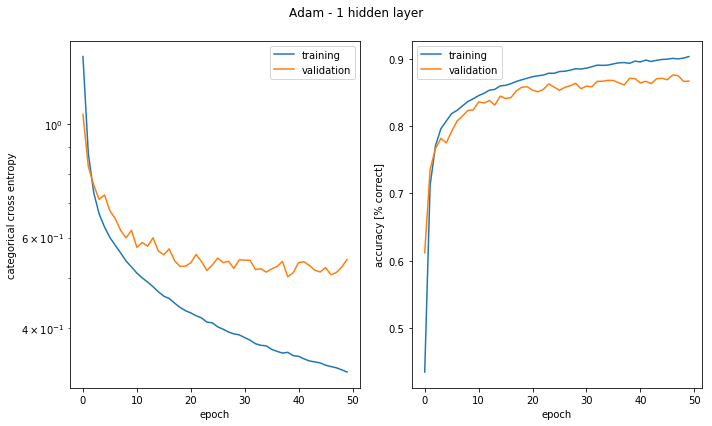

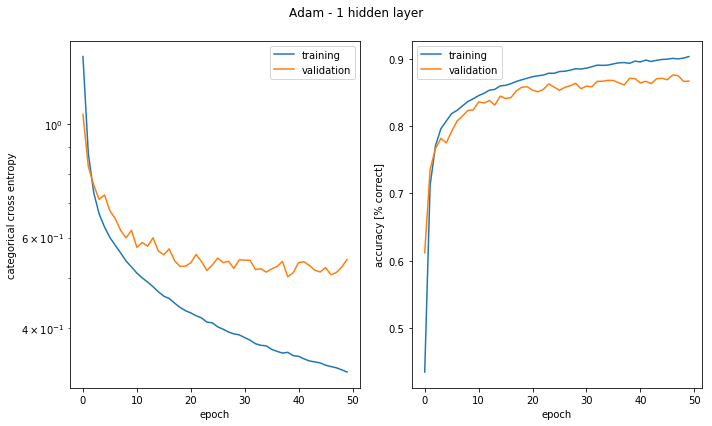

In [15]:
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model2.summary()
history_adam = model2.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_test, y_test))
plot_history(history_adam, title="Adam - 1 hidden layer")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Train on 40427 samples, validate on 14839 samples
Epoch 1/50
40427/40427 [==============================] - 2s 52us/step - loss: 1.4253 - acc: 0.4063 - val_loss: 1.6067 - val_acc: 0.3558
Epoch 2/50
40427/40427 [==============================] - 1s 33us/step - loss: 1.6090 - acc: 0.3391 - val_loss: 1.6092 - val_acc: 0.3426
Epoch 3/50
40427/40427 [==============================] - 1s 30us/step - loss: 1.6094 - acc: 0.3368 - val_loss: 1.6091 - val_acc: 0.3438
Epoch 4/50
40427/40427 [==============================] - 1s 31us/step - 

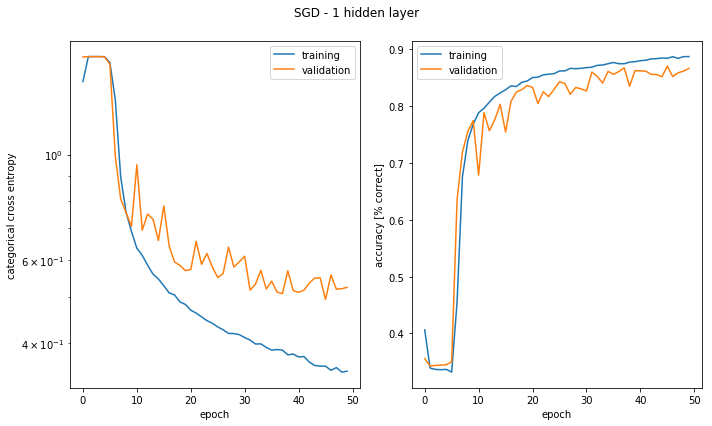

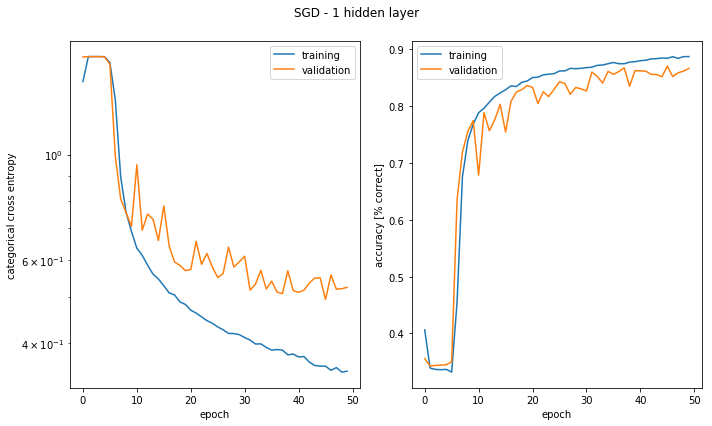

In [16]:
lr = 1.0
model2 = Sequential()

model2.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model2.add(Dense(5, activation='sigmoid', name = 'Y'))

model2.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.summary()
model2.optimizer.lr = lr
history_sgd = model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))
plot_history(history_sgd, title="SGD - 1 hidden layer")

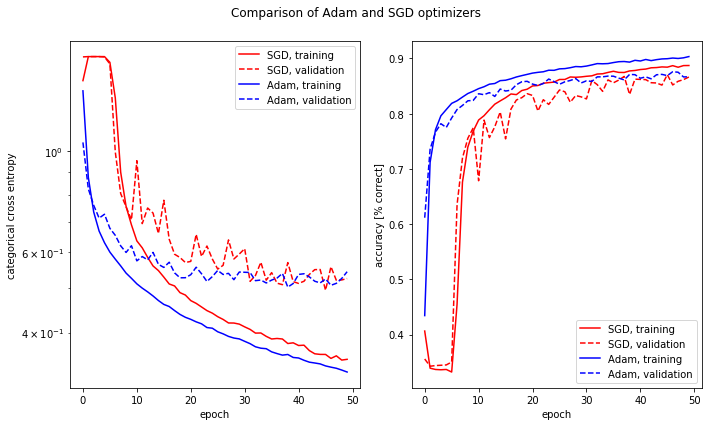

In [17]:
fig, ax1, ax2 = prepare_standardplot("Comparison of Adam and SGD optimizers", 'epoch')
ax1.plot(history_sgd.history['loss'], label = "SGD, training", c='r')
ax1.plot(history_sgd.history['val_loss'], label = "SGD, validation", c='r', linestyle='--')
ax1.plot(history_adam.history['loss'], label = "Adam, training", c='b')
ax1.plot(history_adam.history['val_loss'], label = "Adam, validation", c='b', linestyle='--')
ax2.plot(history_sgd.history['acc'], label = "SGD, training", c='r')
ax2.plot(history_sgd.history['val_acc'], label = "SGD, validation", c='r', linestyle='--')
ax2.plot(history_adam.history['acc'], label = "Adam, training", c='b')
ax2.plot(history_adam.history['val_acc'], label = "Adam, validation", c='b', linestyle='--')
finalize_standardplot(fig, ax1, ax2)

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Train on 36384 samples, validate on 4043 samples
Epoch 1/100
36384/36384 [==============================] - 5s 138us/step - loss: 1.3322 - acc: 0.4443 - val_loss: 1.0241 - val_acc: 0.6072
Epoch 2/100
36384/36384 [==============================] - 5s 136us/step - loss: 0.9133 - acc: 0.6869 - val_loss: 0.8263 - val_acc: 0.7185
Epoch 3/100
36384/36384 [==============================] - 6s 157us/step - loss: 0.7842 - acc: 0.7457 - val_loss: 0.7733 - val_acc: 0.7583
Epoch 4/100
36384/36384 [==============================] - 4s 96us/s

36384/36384 [==============================] - 4s 117us/step - loss: 0.3256 - acc: 0.9018 - val_loss: 0.4528 - val_acc: 0.8714
Epoch 56/100
36384/36384 [==============================] - 4s 117us/step - loss: 0.3261 - acc: 0.9011 - val_loss: 0.4208 - val_acc: 0.8835
Epoch 57/100
36384/36384 [==============================] - 5s 126us/step - loss: 0.3224 - acc: 0.9025 - val_loss: 0.4531 - val_acc: 0.8721
Epoch 58/100
36384/36384 [==============================] - 4s 123us/step - loss: 0.3186 - acc: 0.9040 - val_loss: 0.4354 - val_acc: 0.8835
Epoch 59/100
36384/36384 [==============================] - 4s 122us/step - loss: 0.3195 - acc: 0.9025 - val_loss: 0.4713 - val_acc: 0.8739
Epoch 60/100
36384/36384 [==============================] - 5s 125us/step - loss: 0.3135 - acc: 0.9044 - val_loss: 0.4340 - val_acc: 0.8833
Epoch 61/100
36384/36384 [==============================] - 4s 116us/step - loss: 0.3138 - acc: 0.9046 - val_loss: 0.4474 - val_acc: 0.8768
Epoch 62/100
36384/36384 [=======

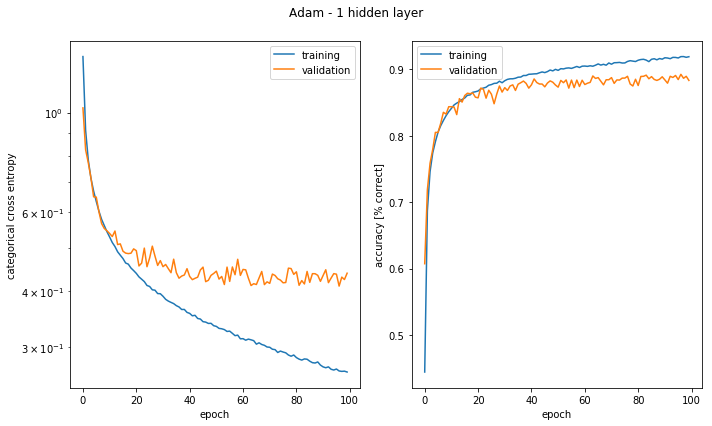

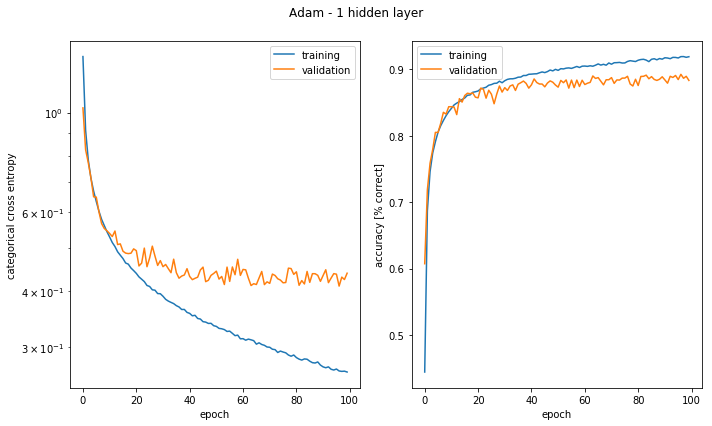

In [18]:
model = Sequential()

model.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model.add(Dense(5, activation='sigmoid', name = 'Y'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs=100, verbose=1, validation_set = (x_test, y_test))
plot_history(history, title="Adam - 1 hidden layer")

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: After 30-40 epochs, we can see overfitting, characterized by the divergence of the training and validation loss.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

#### 10 hidden neurons

Train on 40427 samples, validate on 14839 samples
Epoch 1/100
40427/40427 [==============================] - 6s 138us/step - loss: 1.4727 - acc: 0.3484 - val_loss: 1.3494 - val_acc: 0.4048
Epoch 2/100
40427/40427 [==============================] - 5s 112us/step - loss: 1.2533 - acc: 0.4644 - val_loss: 1.1847 - val_acc: 0.5179
Epoch 3/100
40427/40427 [==============================] - 5s 129us/step - loss: 1.0848 - acc: 0.5793 - val_loss: 1.0534 - val_acc: 0.6214
Epoch 4/100
40427/40427 [==============================] - 7s 163us/step - loss: 0.9531 - acc: 0.6593 - val_loss: 0.9799 - val_acc: 0.6533
Epoch 5/100
40427/40427 [==============================] - 6s 155us/step - loss: 0.8925 - acc: 0.6844 - val_loss: 0.9428 - val_acc: 0.6682
Epoch 6/100
40427/40427 [==============================] - 7s 164us/step - loss: 0.8606 - acc: 0.6981 - val_loss: 0.9306 - val_acc: 0.6824
Epoch 7/100
40427/40427 [==============================] - 5s 126us/step - loss: 0.8397 - acc: 0.7092 - val_loss: 0.

40427/40427 [==============================] - 3s 74us/step - loss: 0.6386 - acc: 0.8070 - val_loss: 0.8159 - val_acc: 0.7672
Epoch 60/100
40427/40427 [==============================] - 3s 75us/step - loss: 0.6389 - acc: 0.8074 - val_loss: 0.8053 - val_acc: 0.7740
Epoch 61/100
40427/40427 [==============================] - 3s 75us/step - loss: 0.6370 - acc: 0.8077 - val_loss: 0.7980 - val_acc: 0.7743
Epoch 62/100
40427/40427 [==============================] - 3s 77us/step - loss: 0.6367 - acc: 0.8087 - val_loss: 0.7891 - val_acc: 0.7767
Epoch 63/100
40427/40427 [==============================] - 3s 80us/step - loss: 0.6364 - acc: 0.8070 - val_loss: 0.7950 - val_acc: 0.7754
Epoch 64/100
40427/40427 [==============================] - 5s 132us/step - loss: 0.6366 - acc: 0.8072 - val_loss: 0.7973 - val_acc: 0.7722
Epoch 65/100
40427/40427 [==============================] - 8s 193us/step - loss: 0.6379 - acc: 0.8062 - val_loss: 0.8017 - val_acc: 0.7736
Epoch 66/100
40427/40427 [============

Epoch 17/100
40427/40427 [==============================] - 3s 78us/step - loss: 0.7761 - acc: 0.7495 - val_loss: 0.9326 - val_acc: 0.6930
Epoch 18/100
40427/40427 [==============================] - 4s 90us/step - loss: 0.7724 - acc: 0.7495 - val_loss: 0.9586 - val_acc: 0.6965
Epoch 19/100
40427/40427 [==============================] - 3s 87us/step - loss: 0.7674 - acc: 0.7511 - val_loss: 0.9168 - val_acc: 0.7148
Epoch 20/100
40427/40427 [==============================] - 3s 75us/step - loss: 0.7666 - acc: 0.7547 - val_loss: 0.9266 - val_acc: 0.7098
Epoch 21/100
40427/40427 [==============================] - 3s 82us/step - loss: 0.7602 - acc: 0.7549 - val_loss: 0.9114 - val_acc: 0.7075
Epoch 22/100
40427/40427 [==============================] - 3s 77us/step - loss: 0.7565 - acc: 0.7552 - val_loss: 0.9051 - val_acc: 0.7181
Epoch 23/100
40427/40427 [==============================] - 3s 75us/step - loss: 0.7560 - acc: 0.7566 - val_loss: 0.9237 - val_acc: 0.7132
Epoch 24/100
40427/40427 [=

Epoch 76/100
40427/40427 [==============================] - 4s 111us/step - loss: 0.6953 - acc: 0.7814 - val_loss: 0.8970 - val_acc: 0.7377
Epoch 77/100
40427/40427 [==============================] - 5s 125us/step - loss: 0.6943 - acc: 0.7827 - val_loss: 0.8869 - val_acc: 0.7366
Epoch 78/100
40427/40427 [==============================] - 4s 104us/step - loss: 0.6954 - acc: 0.7832 - val_loss: 0.8959 - val_acc: 0.7316
Epoch 79/100
40427/40427 [==============================] - 10s 258us/step - loss: 0.6924 - acc: 0.7829 - val_loss: 0.9064 - val_acc: 0.7354
Epoch 80/100
40427/40427 [==============================] - 4s 94us/step - loss: 0.6925 - acc: 0.7833 - val_loss: 0.8866 - val_acc: 0.7399
Epoch 81/100
40427/40427 [==============================] - 4s 95us/step - loss: 0.6909 - acc: 0.7835 - val_loss: 0.8883 - val_acc: 0.7374
Epoch 82/100
40427/40427 [==============================] - 3s 79us/step - loss: 0.6897 - acc: 0.7850 - val_loss: 0.8781 - val_acc: 0.7387
Epoch 83/100
40427/404

Epoch 34/100
40427/40427 [==============================] - 4s 87us/step - loss: 0.7318 - acc: 0.7698 - val_loss: 0.8836 - val_acc: 0.7277
Epoch 35/100
40427/40427 [==============================] - 3s 77us/step - loss: 0.7288 - acc: 0.7683 - val_loss: 0.8805 - val_acc: 0.7283
Epoch 36/100
40427/40427 [==============================] - 8s 190us/step - loss: 0.7270 - acc: 0.7709 - val_loss: 0.8995 - val_acc: 0.7240
Epoch 37/100
40427/40427 [==============================] - 6s 141us/step - loss: 0.7249 - acc: 0.7717 - val_loss: 0.8812 - val_acc: 0.7280
Epoch 38/100
40427/40427 [==============================] - 6s 146us/step - loss: 0.7230 - acc: 0.7717 - val_loss: 0.8874 - val_acc: 0.7321
Epoch 39/100
40427/40427 [==============================] - 5s 131us/step - loss: 0.7212 - acc: 0.7728 - val_loss: 0.9056 - val_acc: 0.7224
Epoch 40/100
40427/40427 [==============================] - 5s 132us/step - loss: 0.7217 - acc: 0.7708 - val_loss: 0.8851 - val_acc: 0.7300
Epoch 41/100
40427/404

40427/40427 [==============================] - 5s 126us/step - loss: 0.6780 - acc: 0.7911 - val_loss: 0.8881 - val_acc: 0.7402
Epoch 93/100
40427/40427 [==============================] - 5s 131us/step - loss: 0.6791 - acc: 0.7905 - val_loss: 0.8773 - val_acc: 0.7405
Epoch 94/100
40427/40427 [==============================] - 4s 98us/step - loss: 0.6789 - acc: 0.7902 - val_loss: 0.8797 - val_acc: 0.7413
Epoch 95/100
40427/40427 [==============================] - 4s 100us/step - loss: 0.6783 - acc: 0.7900 - val_loss: 0.8792 - val_acc: 0.7403
Epoch 96/100
40427/40427 [==============================] - 5s 125us/step - loss: 0.6792 - acc: 0.7898 - val_loss: 0.8803 - val_acc: 0.7412
Epoch 97/100
40427/40427 [==============================] - 7s 184us/step - loss: 0.6792 - acc: 0.7901 - val_loss: 0.8847 - val_acc: 0.7430
Epoch 98/100
40427/40427 [==============================] - 4s 88us/step - loss: 0.6776 - acc: 0.7923 - val_loss: 0.8627 - val_acc: 0.7472
Epoch 99/100
40427/40427 [=========

Epoch 50/100
40427/40427 [==============================] - 3s 76us/step - loss: 0.7196 - acc: 0.7758 - val_loss: 0.8872 - val_acc: 0.7416
Epoch 51/100
40427/40427 [==============================] - 3s 77us/step - loss: 0.7200 - acc: 0.7772 - val_loss: 0.8937 - val_acc: 0.7394
Epoch 52/100
40427/40427 [==============================] - 3s 77us/step - loss: 0.7167 - acc: 0.7765 - val_loss: 0.8967 - val_acc: 0.7410
Epoch 53/100
40427/40427 [==============================] - 3s 79us/step - loss: 0.7186 - acc: 0.7759 - val_loss: 0.8997 - val_acc: 0.7395
Epoch 54/100
40427/40427 [==============================] - 3s 79us/step - loss: 0.7174 - acc: 0.7773 - val_loss: 0.9023 - val_acc: 0.7335
Epoch 55/100
40427/40427 [==============================] - 3s 77us/step - loss: 0.7167 - acc: 0.7760 - val_loss: 0.8969 - val_acc: 0.7420
Epoch 56/100
40427/40427 [==============================] - 3s 76us/step - loss: 0.7161 - acc: 0.7764 - val_loss: 0.8852 - val_acc: 0.7430
Epoch 57/100
40427/40427 [=

Epoch 8/100
40427/40427 [==============================] - 3s 77us/step - loss: 0.9621 - acc: 0.6671 - val_loss: 1.0678 - val_acc: 0.6486
Epoch 9/100
40427/40427 [==============================] - 3s 78us/step - loss: 0.9460 - acc: 0.6755 - val_loss: 1.0205 - val_acc: 0.6623
Epoch 10/100
40427/40427 [==============================] - 3s 78us/step - loss: 0.9332 - acc: 0.6832 - val_loss: 1.0119 - val_acc: 0.6666
Epoch 11/100
40427/40427 [==============================] - 3s 79us/step - loss: 0.9240 - acc: 0.6884 - val_loss: 1.0834 - val_acc: 0.6395
Epoch 12/100
40427/40427 [==============================] - 3s 83us/step - loss: 0.9137 - acc: 0.6928 - val_loss: 1.0093 - val_acc: 0.6676
Epoch 13/100
40427/40427 [==============================] - 3s 78us/step - loss: 0.9048 - acc: 0.6972 - val_loss: 1.0506 - val_acc: 0.6636
Epoch 14/100
40427/40427 [==============================] - 3s 79us/step - loss: 0.8991 - acc: 0.6995 - val_loss: 1.0187 - val_acc: 0.6642
Epoch 15/100
40427/40427 [===

Epoch 67/100
40427/40427 [==============================] - 5s 133us/step - loss: 0.8182 - acc: 0.7361 - val_loss: 1.0051 - val_acc: 0.6914
Epoch 68/100
40427/40427 [==============================] - 6s 146us/step - loss: 0.8211 - acc: 0.7364 - val_loss: 0.9910 - val_acc: 0.6949
Epoch 69/100
40427/40427 [==============================] - 6s 148us/step - loss: 0.8185 - acc: 0.7355 - val_loss: 0.9743 - val_acc: 0.6957
Epoch 70/100
40427/40427 [==============================] - 4s 96us/step - loss: 0.8188 - acc: 0.7371 - val_loss: 1.0262 - val_acc: 0.6893
Epoch 71/100
40427/40427 [==============================] - 5s 130us/step - loss: 0.8184 - acc: 0.7375 - val_loss: 0.9890 - val_acc: 0.6982
Epoch 72/100
40427/40427 [==============================] - 6s 146us/step - loss: 0.8171 - acc: 0.7371 - val_loss: 1.0047 - val_acc: 0.6941
Epoch 73/100
40427/40427 [==============================] - 4s 99us/step - loss: 0.8178 - acc: 0.7370 - val_loss: 0.9912 - val_acc: 0.6936
Epoch 74/100
40427/404

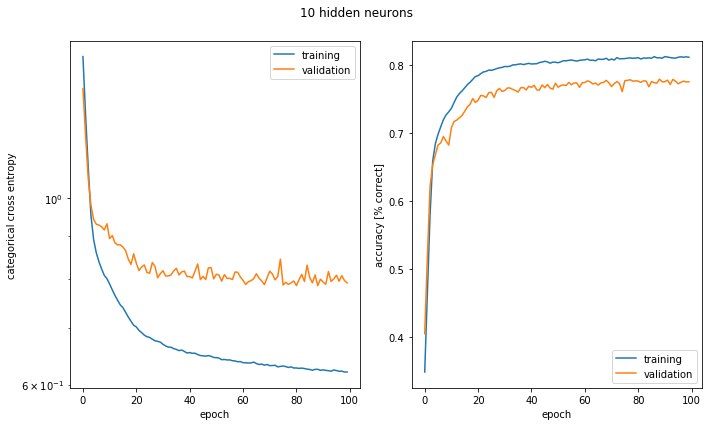

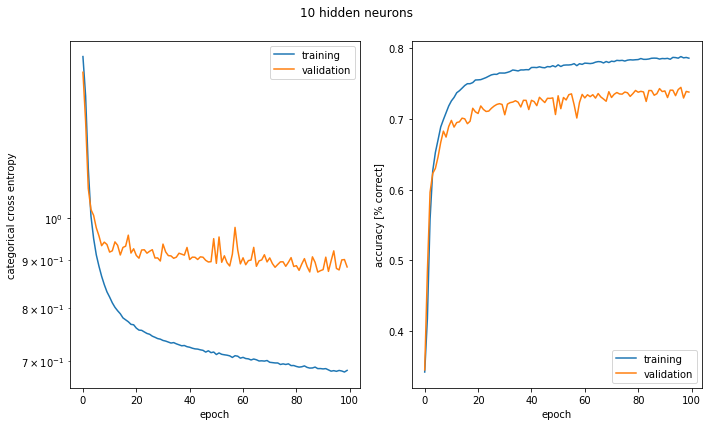

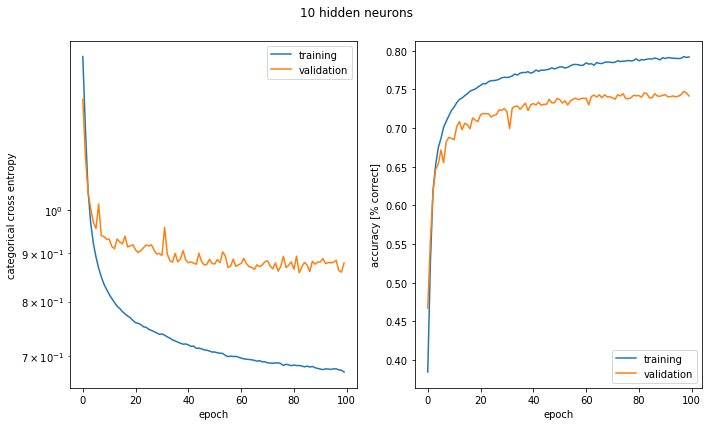

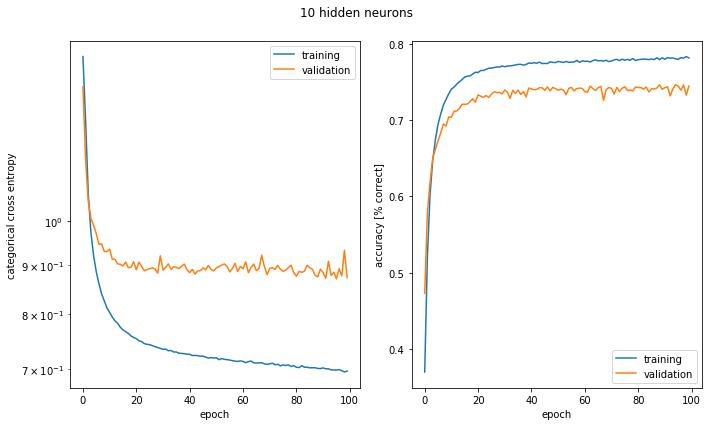

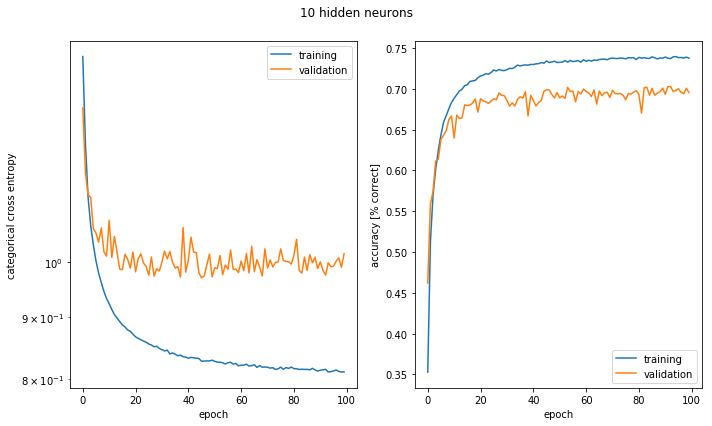

In [12]:
scores = []
for i in range(5):
    model1 = Sequential()
    model1.add(Dense(10, input_dim=256, activation='relu', name="H1"))
    model1.add(Dense(5, activation='sigmoid', name = 'Y'))
    model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model1.fit(x_train, y_train, epochs=100, verbose=1, validation_data=(x_test, y_test))
    scores.append(model1.evaluate(x_test, y_test))
    plot_history(history, title="10 hidden neurons")

In [13]:
accuracies = []
accuracies.append([score[1] for score in scores])
losses = []
losses.append([score[0] for score in scores])
print(accuracies)
print(losses)

[[0.7754565671742046, 0.7376507851134189, 0.7413572343350646, 0.7448615135389146, 0.6952624840149622]]
[[0.7924720719542029, 0.8855307615303802, 0.878995383096694, 0.873200718809776, 1.0164143992158006]]


#### 100 hidden neurons

Train on 40427 samples, validate on 14839 samples
Epoch 1/100
40427/40427 [==============================] - 8s 186us/step - loss: 1.2168 - acc: 0.5129 - val_loss: 0.9008 - val_acc: 0.6993
Epoch 2/100
40427/40427 [==============================] - 7s 173us/step - loss: 0.7894 - acc: 0.7475 - val_loss: 0.7694 - val_acc: 0.7592
Epoch 3/100
40427/40427 [==============================] - 7s 165us/step - loss: 0.6817 - acc: 0.7880 - val_loss: 0.7385 - val_acc: 0.7730
Epoch 4/100
40427/40427 [==============================] - 7s 168us/step - loss: 0.6267 - acc: 0.8066 - val_loss: 0.7126 - val_acc: 0.7846
Epoch 5/100
40427/40427 [==============================] - 7s 167us/step - loss: 0.5837 - acc: 0.8212 - val_loss: 0.6887 - val_acc: 0.7894
Epoch 6/100
40427/40427 [==============================] - 7s 172us/step - loss: 0.5555 - acc: 0.8288 - val_loss: 0.6379 - val_acc: 0.8082
Epoch 7/100
40427/40427 [==============================] - 7s 169us/step - loss: 0.5282 - acc: 0.8389 - val_loss: 0.

40427/40427 [==============================] - 7s 164us/step - loss: 0.2529 - acc: 0.9216 - val_loss: 0.5103 - val_acc: 0.8788
Epoch 60/100
40427/40427 [==============================] - 7s 161us/step - loss: 0.2524 - acc: 0.9214 - val_loss: 0.4985 - val_acc: 0.8836
Epoch 61/100
40427/40427 [==============================] - 7s 161us/step - loss: 0.2486 - acc: 0.9246 - val_loss: 0.5186 - val_acc: 0.8779
Epoch 62/100
40427/40427 [==============================] - 7s 163us/step - loss: 0.2481 - acc: 0.9245 - val_loss: 0.5217 - val_acc: 0.8771
Epoch 63/100
40427/40427 [==============================] - 7s 162us/step - loss: 0.2447 - acc: 0.9252 - val_loss: 0.5102 - val_acc: 0.8807
Epoch 64/100
40427/40427 [==============================] - 6s 159us/step - loss: 0.2438 - acc: 0.9251 - val_loss: 0.5126 - val_acc: 0.8824
Epoch 65/100
40427/40427 [==============================] - 7s 164us/step - loss: 0.2426 - acc: 0.9256 - val_loss: 0.5109 - val_acc: 0.8817
Epoch 66/100
40427/40427 [=======

Epoch 17/100
40427/40427 [==============================] - 7s 172us/step - loss: 0.3974 - acc: 0.8793 - val_loss: 0.5159 - val_acc: 0.8585
Epoch 18/100
40427/40427 [==============================] - 7s 165us/step - loss: 0.3888 - acc: 0.8825 - val_loss: 0.5178 - val_acc: 0.8577
Epoch 19/100
40427/40427 [==============================] - 7s 163us/step - loss: 0.3826 - acc: 0.8832 - val_loss: 0.5397 - val_acc: 0.8513
Epoch 20/100
40427/40427 [==============================] - 7s 161us/step - loss: 0.3732 - acc: 0.8883 - val_loss: 0.5195 - val_acc: 0.8579
Epoch 21/100
40427/40427 [==============================] - 7s 166us/step - loss: 0.3697 - acc: 0.8881 - val_loss: 0.5016 - val_acc: 0.8649
Epoch 22/100
40427/40427 [==============================] - 7s 164us/step - loss: 0.3597 - acc: 0.8917 - val_loss: 0.5121 - val_acc: 0.8665
Epoch 23/100
40427/40427 [==============================] - 7s 165us/step - loss: 0.3555 - acc: 0.8922 - val_loss: 0.5278 - val_acc: 0.8604
Epoch 24/100
40427/4

40427/40427 [==============================] - 6s 159us/step - loss: 0.2214 - acc: 0.9308 - val_loss: 0.5160 - val_acc: 0.8846
Epoch 76/100
40427/40427 [==============================] - 7s 179us/step - loss: 0.2173 - acc: 0.9326 - val_loss: 0.5399 - val_acc: 0.8778
Epoch 77/100
40427/40427 [==============================] - 6s 148us/step - loss: 0.2196 - acc: 0.9325 - val_loss: 0.5163 - val_acc: 0.8860
Epoch 78/100
40427/40427 [==============================] - 6s 145us/step - loss: 0.2156 - acc: 0.9336 - val_loss: 0.5409 - val_acc: 0.8825
Epoch 79/100
40427/40427 [==============================] - 6s 147us/step - loss: 0.2169 - acc: 0.9333 - val_loss: 0.5183 - val_acc: 0.8832
Epoch 80/100
40427/40427 [==============================] - 6s 151us/step - loss: 0.2155 - acc: 0.9334 - val_loss: 0.5118 - val_acc: 0.8883
Epoch 81/100
40427/40427 [==============================] - 6s 146us/step - loss: 0.2146 - acc: 0.9338 - val_loss: 0.5363 - val_acc: 0.8769
Epoch 82/100
40427/40427 [=======

Epoch 33/100
40427/40427 [==============================] - 5s 112us/step - loss: 0.3193 - acc: 0.9021 - val_loss: 0.4890 - val_acc: 0.8748
Epoch 34/100
40427/40427 [==============================] - 5s 113us/step - loss: 0.3155 - acc: 0.9050 - val_loss: 0.4860 - val_acc: 0.8736
Epoch 35/100
40427/40427 [==============================] - 5s 119us/step - loss: 0.3097 - acc: 0.9058 - val_loss: 0.5057 - val_acc: 0.8702
Epoch 36/100
40427/40427 [==============================] - 5s 112us/step - loss: 0.3043 - acc: 0.9074 - val_loss: 0.4931 - val_acc: 0.8759
Epoch 37/100
40427/40427 [==============================] - 5s 114us/step - loss: 0.3051 - acc: 0.9062 - val_loss: 0.4821 - val_acc: 0.8805
Epoch 38/100
40427/40427 [==============================] - 5s 111us/step - loss: 0.3000 - acc: 0.9093 - val_loss: 0.5078 - val_acc: 0.8708
Epoch 39/100
40427/40427 [==============================] - 5s 113us/step - loss: 0.2987 - acc: 0.9093 - val_loss: 0.4972 - val_acc: 0.8765
Epoch 40/100
40427/4

40427/40427 [==============================] - 5s 112us/step - loss: 0.2093 - acc: 0.9355 - val_loss: 0.5344 - val_acc: 0.8893
Epoch 92/100
40427/40427 [==============================] - 4s 111us/step - loss: 0.2033 - acc: 0.9372 - val_loss: 0.5309 - val_acc: 0.8878
Epoch 93/100
40427/40427 [==============================] - 5s 111us/step - loss: 0.2035 - acc: 0.9361 - val_loss: 0.5248 - val_acc: 0.8902
Epoch 94/100
40427/40427 [==============================] - 4s 110us/step - loss: 0.2023 - acc: 0.9363 - val_loss: 0.5403 - val_acc: 0.8847
Epoch 95/100
40427/40427 [==============================] - 4s 111us/step - loss: 0.2020 - acc: 0.9378 - val_loss: 0.5529 - val_acc: 0.8830
Epoch 96/100
40427/40427 [==============================] - 5s 112us/step - loss: 0.2016 - acc: 0.9362 - val_loss: 0.5312 - val_acc: 0.8856
Epoch 97/100
40427/40427 [==============================] - 5s 112us/step - loss: 0.2027 - acc: 0.9366 - val_loss: 0.5284 - val_acc: 0.8857
Epoch 98/100
40427/40427 [=======

40427/40427 [==============================] - 5s 121us/step - loss: 0.2838 - acc: 0.9130 - val_loss: 0.5075 - val_acc: 0.8753
Epoch 49/100
40427/40427 [==============================] - 5s 119us/step - loss: 0.2835 - acc: 0.9137 - val_loss: 0.5040 - val_acc: 0.8765
Epoch 50/100
40427/40427 [==============================] - 5s 120us/step - loss: 0.2808 - acc: 0.9135 - val_loss: 0.4933 - val_acc: 0.8776
Epoch 51/100
40427/40427 [==============================] - 5s 120us/step - loss: 0.2769 - acc: 0.9146 - val_loss: 0.5026 - val_acc: 0.8771
Epoch 52/100
40427/40427 [==============================] - 5s 119us/step - loss: 0.2725 - acc: 0.9155 - val_loss: 0.5157 - val_acc: 0.8752
Epoch 53/100
40427/40427 [==============================] - 5s 120us/step - loss: 0.2734 - acc: 0.9177 - val_loss: 0.5715 - val_acc: 0.8570
Epoch 54/100
40427/40427 [==============================] - 5s 121us/step - loss: 0.2714 - acc: 0.9167 - val_loss: 0.5024 - val_acc: 0.8782
Epoch 55/100
40427/40427 [=======

Epoch 6/100
40427/40427 [==============================] - 6s 152us/step - loss: 0.5549 - acc: 0.8317 - val_loss: 0.6254 - val_acc: 0.8215
Epoch 7/100
40427/40427 [==============================] - 6s 152us/step - loss: 0.5276 - acc: 0.8398 - val_loss: 0.6194 - val_acc: 0.8189
Epoch 8/100
40427/40427 [==============================] - 6s 160us/step - loss: 0.5088 - acc: 0.8450 - val_loss: 0.6023 - val_acc: 0.8280
Epoch 9/100
40427/40427 [==============================] - 6s 151us/step - loss: 0.4924 - acc: 0.8505 - val_loss: 0.6184 - val_acc: 0.8216
Epoch 10/100
40427/40427 [==============================] - 6s 153us/step - loss: 0.4748 - acc: 0.8570 - val_loss: 0.5885 - val_acc: 0.8268
Epoch 11/100
40427/40427 [==============================] - 6s 151us/step - loss: 0.4637 - acc: 0.8597 - val_loss: 0.5641 - val_acc: 0.8412
Epoch 12/100
40427/40427 [==============================] - 6s 154us/step - loss: 0.4484 - acc: 0.8629 - val_loss: 0.5685 - val_acc: 0.8426
Epoch 13/100
40427/40427

40427/40427 [==============================] - 6s 149us/step - loss: 0.2535 - acc: 0.9213 - val_loss: 0.5102 - val_acc: 0.8794
Epoch 65/100
40427/40427 [==============================] - 6s 154us/step - loss: 0.2519 - acc: 0.9211 - val_loss: 0.5091 - val_acc: 0.8792
Epoch 66/100
40427/40427 [==============================] - 6s 152us/step - loss: 0.2486 - acc: 0.9228 - val_loss: 0.5030 - val_acc: 0.8821
Epoch 67/100
40427/40427 [==============================] - 6s 154us/step - loss: 0.2488 - acc: 0.9216 - val_loss: 0.5031 - val_acc: 0.8816
Epoch 68/100
40427/40427 [==============================] - 6s 150us/step - loss: 0.2442 - acc: 0.9247 - val_loss: 0.5063 - val_acc: 0.8809
Epoch 69/100
40427/40427 [==============================] - 6s 150us/step - loss: 0.2471 - acc: 0.9242 - val_loss: 0.5395 - val_acc: 0.8738
Epoch 70/100
40427/40427 [==============================] - 7s 164us/step - loss: 0.2443 - acc: 0.9239 - val_loss: 0.5208 - val_acc: 0.8797
Epoch 71/100
40427/40427 [=======

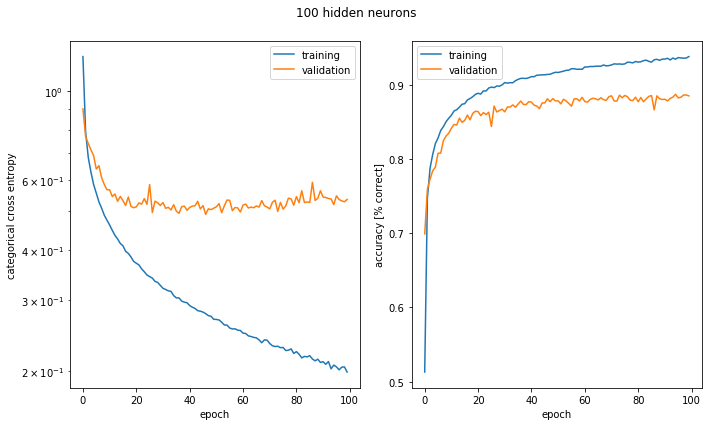

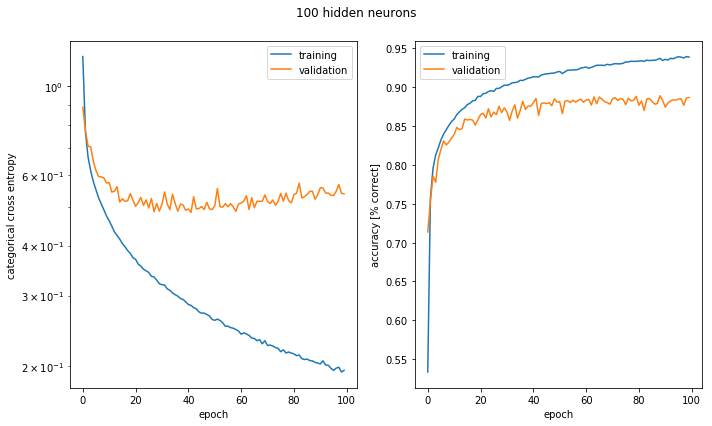

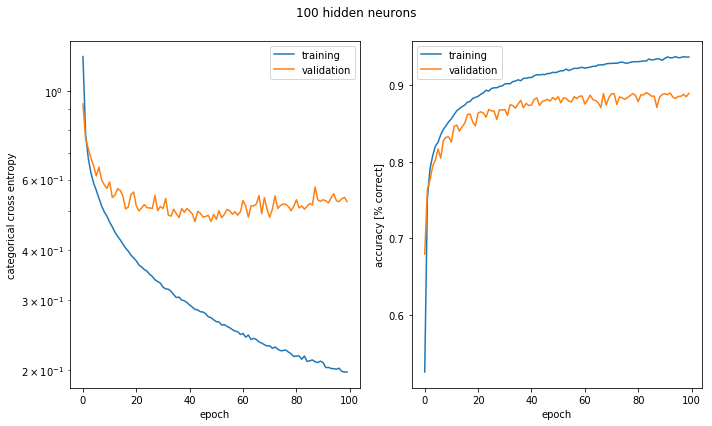

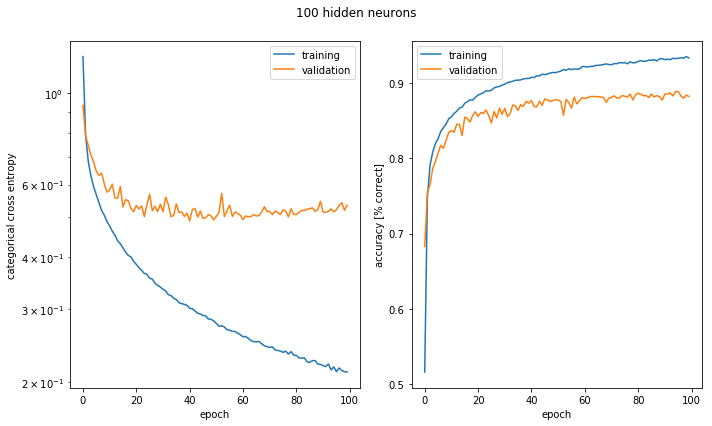

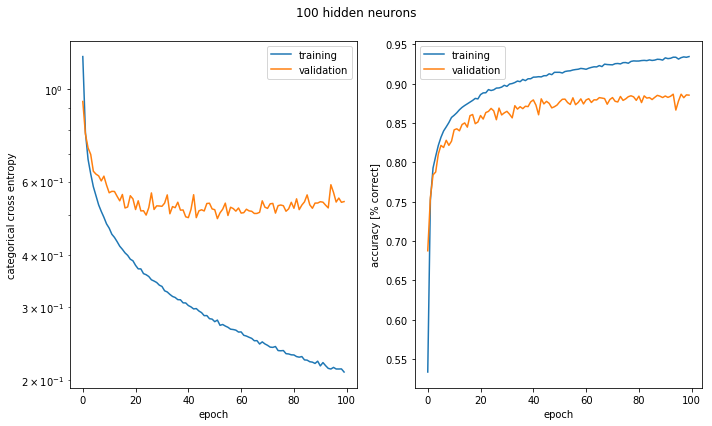

In [14]:
scores = []
for i in range(5):
    model = Sequential()
    model.add(Dense(100, input_dim=256, activation='relu', name="H1"))
    model.add(Dense(5, activation='sigmoid', name = 'Y'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, verbose=1, validation_data=(x_test, y_test))
    scores.append(model.evaluate(x_test, y_test))
    plot_history(history, title="100 hidden neurons")

In [15]:
accuracies.append([score[1] for score in scores])
losses.append([score[0] for score in scores])

#### 1000 hidden neurons

Train on 40427 samples, validate on 14839 samples
Epoch 1/100
40427/40427 [==============================] - 26s 635us/step - loss: 1.0458 - acc: 0.6044 - val_loss: 0.7861 - val_acc: 0.7444
Epoch 2/100
40427/40427 [==============================] - 19s 464us/step - loss: 0.6781 - acc: 0.7857 - val_loss: 0.6850 - val_acc: 0.7863
Epoch 3/100
40427/40427 [==============================] - 22s 537us/step - loss: 0.5939 - acc: 0.8152 - val_loss: 0.6220 - val_acc: 0.8105
Epoch 4/100
40427/40427 [==============================] - 36s 888us/step - loss: 0.5396 - acc: 0.8328 - val_loss: 0.6656 - val_acc: 0.7999
Epoch 5/100
40427/40427 [==============================] - 31s 766us/step - loss: 0.5038 - acc: 0.8442 - val_loss: 0.5734 - val_acc: 0.8358
Epoch 6/100
40427/40427 [==============================] - 27s 663us/step - loss: 0.4722 - acc: 0.8537 - val_loss: 0.5772 - val_acc: 0.8292
Epoch 7/100
40427/40427 [==============================] - 30s 740us/step - loss: 0.4436 - acc: 0.8632 - val_l

Epoch 59/100
40427/40427 [==============================] - 18s 447us/step - loss: 0.1303 - acc: 0.9561 - val_loss: 0.6762 - val_acc: 0.8720
Epoch 60/100
40427/40427 [==============================] - 18s 449us/step - loss: 0.1325 - acc: 0.9562 - val_loss: 0.6287 - val_acc: 0.8823
Epoch 61/100
40427/40427 [==============================] - 18s 448us/step - loss: 0.1259 - acc: 0.9591 - val_loss: 0.6259 - val_acc: 0.8838
Epoch 62/100
40427/40427 [==============================] - 18s 444us/step - loss: 0.1262 - acc: 0.9590 - val_loss: 0.6192 - val_acc: 0.8903
Epoch 63/100
40427/40427 [==============================] - 19s 461us/step - loss: 0.1227 - acc: 0.9598 - val_loss: 0.6247 - val_acc: 0.8813
Epoch 64/100
40427/40427 [==============================] - 18s 454us/step - loss: 0.1256 - acc: 0.9588 - val_loss: 0.6083 - val_acc: 0.8879
Epoch 65/100
40427/40427 [==============================] - 18s 447us/step - loss: 0.1230 - acc: 0.9601 - val_loss: 0.6806 - val_acc: 0.8766
Epoch 66/100


40427/40427 [==============================] - 20s 495us/step - loss: 0.3194 - acc: 0.8982 - val_loss: 0.4972 - val_acc: 0.8682
Epoch 17/100
40427/40427 [==============================] - 20s 493us/step - loss: 0.3070 - acc: 0.9048 - val_loss: 0.4786 - val_acc: 0.8748
Epoch 18/100
40427/40427 [==============================] - 20s 492us/step - loss: 0.3003 - acc: 0.9055 - val_loss: 0.4974 - val_acc: 0.8687
Epoch 19/100
40427/40427 [==============================] - 20s 492us/step - loss: 0.2887 - acc: 0.9102 - val_loss: 0.4668 - val_acc: 0.8815
Epoch 20/100
40427/40427 [==============================] - 20s 498us/step - loss: 0.2869 - acc: 0.9105 - val_loss: 0.5081 - val_acc: 0.8714
Epoch 21/100
40427/40427 [==============================] - 20s 493us/step - loss: 0.2769 - acc: 0.9121 - val_loss: 0.5097 - val_acc: 0.8762
Epoch 22/100
40427/40427 [==============================] - 20s 495us/step - loss: 0.2713 - acc: 0.9133 - val_loss: 0.4977 - val_acc: 0.8755
Epoch 23/100
40427/40427 [

40427/40427 [==============================] - 20s 493us/step - loss: 0.1071 - acc: 0.9648 - val_loss: 0.6984 - val_acc: 0.8817
Epoch 75/100
40427/40427 [==============================] - 20s 494us/step - loss: 0.1008 - acc: 0.9670 - val_loss: 0.6995 - val_acc: 0.8838
Epoch 76/100
40427/40427 [==============================] - 20s 495us/step - loss: 0.1033 - acc: 0.9651 - val_loss: 0.7153 - val_acc: 0.8777
Epoch 77/100
40427/40427 [==============================] - 20s 491us/step - loss: 0.1006 - acc: 0.9674 - val_loss: 0.6974 - val_acc: 0.8811
Epoch 78/100
40427/40427 [==============================] - 20s 493us/step - loss: 0.1029 - acc: 0.9665 - val_loss: 0.6776 - val_acc: 0.8878
Epoch 79/100
40427/40427 [==============================] - 20s 492us/step - loss: 0.0977 - acc: 0.9674 - val_loss: 0.6632 - val_acc: 0.8867
Epoch 80/100
40427/40427 [==============================] - 20s 493us/step - loss: 0.0971 - acc: 0.9673 - val_loss: 0.7327 - val_acc: 0.8817
Epoch 81/100
40427/40427 [

40427/40427 [==============================] - 23s 579us/step - loss: 0.2171 - acc: 0.9319 - val_loss: 0.4922 - val_acc: 0.8847
Epoch 32/100
40427/40427 [==============================] - 23s 580us/step - loss: 0.2144 - acc: 0.9316 - val_loss: 0.5178 - val_acc: 0.8833
Epoch 33/100
40427/40427 [==============================] - 23s 575us/step - loss: 0.2106 - acc: 0.9319 - val_loss: 0.5105 - val_acc: 0.8784
Epoch 34/100
40427/40427 [==============================] - 24s 587us/step - loss: 0.2051 - acc: 0.9357 - val_loss: 0.5235 - val_acc: 0.8818
Epoch 35/100
40427/40427 [==============================] - 24s 594us/step - loss: 0.2035 - acc: 0.9343 - val_loss: 0.5079 - val_acc: 0.8837
Epoch 36/100
40427/40427 [==============================] - 24s 582us/step - loss: 0.1959 - acc: 0.9383 - val_loss: 0.5126 - val_acc: 0.8842
Epoch 37/100
40427/40427 [==============================] - 24s 587us/step - loss: 0.1932 - acc: 0.9385 - val_loss: 0.5187 - val_acc: 0.8854
Epoch 38/100
40427/40427 [

40427/40427 [==============================] - 26s 655us/step - loss: 0.0908 - acc: 0.9707 - val_loss: 0.7129 - val_acc: 0.8885
Epoch 90/100
40427/40427 [==============================] - 25s 616us/step - loss: 0.0889 - acc: 0.9716 - val_loss: 0.7623 - val_acc: 0.8794
Epoch 91/100
40427/40427 [==============================] - 24s 591us/step - loss: 0.0898 - acc: 0.9698 - val_loss: 0.7346 - val_acc: 0.8815
Epoch 92/100
40427/40427 [==============================] - 24s 597us/step - loss: 0.0874 - acc: 0.9711 - val_loss: 0.7033 - val_acc: 0.8870
Epoch 93/100
40427/40427 [==============================] - 24s 595us/step - loss: 0.0917 - acc: 0.9696 - val_loss: 0.7284 - val_acc: 0.8857
Epoch 94/100
40427/40427 [==============================] - 27s 670us/step - loss: 0.0859 - acc: 0.9717 - val_loss: 0.7546 - val_acc: 0.8814
Epoch 95/100
40427/40427 [==============================] - 25s 611us/step - loss: 0.0874 - acc: 0.9720 - val_loss: 0.7535 - val_acc: 0.8825
Epoch 96/100
40427/40427 [

40427/40427 [==============================] - 23s 560us/step - loss: 0.1609 - acc: 0.9469 - val_loss: 0.5905 - val_acc: 0.8813
Epoch 47/100
40427/40427 [==============================] - 23s 571us/step - loss: 0.1621 - acc: 0.9472 - val_loss: 0.5898 - val_acc: 0.8774
Epoch 48/100
40427/40427 [==============================] - 23s 566us/step - loss: 0.1555 - acc: 0.9481 - val_loss: 0.5648 - val_acc: 0.8850
Epoch 49/100
40427/40427 [==============================] - 23s 563us/step - loss: 0.1524 - acc: 0.9507 - val_loss: 0.5585 - val_acc: 0.8876
Epoch 50/100
40427/40427 [==============================] - 23s 563us/step - loss: 0.1490 - acc: 0.9520 - val_loss: 0.5972 - val_acc: 0.8805
Epoch 51/100
40427/40427 [==============================] - 24s 589us/step - loss: 0.1477 - acc: 0.9507 - val_loss: 0.5858 - val_acc: 0.8832
Epoch 52/100
40427/40427 [==============================] - 23s 568us/step - loss: 0.1445 - acc: 0.9532 - val_loss: 0.6049 - val_acc: 0.8794
Epoch 53/100
40427/40427 [

40427/40427 [==============================] - 19s 475us/step - loss: 0.5898 - acc: 0.8148 - val_loss: 0.6917 - val_acc: 0.7924
Epoch 4/100
40427/40427 [==============================] - 19s 479us/step - loss: 0.5416 - acc: 0.8291 - val_loss: 0.6210 - val_acc: 0.8149
Epoch 5/100
40427/40427 [==============================] - 19s 472us/step - loss: 0.5061 - acc: 0.8429 - val_loss: 0.5755 - val_acc: 0.8356
Epoch 6/100
40427/40427 [==============================] - 19s 477us/step - loss: 0.4761 - acc: 0.8522 - val_loss: 0.5629 - val_acc: 0.8364
Epoch 7/100
40427/40427 [==============================] - 20s 483us/step - loss: 0.4490 - acc: 0.8616 - val_loss: 0.5745 - val_acc: 0.8343
Epoch 8/100
40427/40427 [==============================] - 19s 478us/step - loss: 0.4293 - acc: 0.8684 - val_loss: 0.5442 - val_acc: 0.8471
Epoch 9/100
40427/40427 [==============================] - 19s 476us/step - loss: 0.4106 - acc: 0.8711 - val_loss: 0.5289 - val_acc: 0.8509
Epoch 10/100
40427/40427 [======

40427/40427 [==============================] - 19s 477us/step - loss: 0.1235 - acc: 0.9602 - val_loss: 0.6183 - val_acc: 0.8800
Epoch 62/100
40427/40427 [==============================] - 19s 478us/step - loss: 0.1244 - acc: 0.9595 - val_loss: 0.6300 - val_acc: 0.8846
Epoch 63/100
40427/40427 [==============================] - 19s 473us/step - loss: 0.1267 - acc: 0.9579 - val_loss: 0.6535 - val_acc: 0.8782
Epoch 64/100
40427/40427 [==============================] - 20s 484us/step - loss: 0.1200 - acc: 0.9610 - val_loss: 0.6413 - val_acc: 0.8841
Epoch 65/100
40427/40427 [==============================] - 19s 475us/step - loss: 0.1227 - acc: 0.9596 - val_loss: 0.6440 - val_acc: 0.8802
Epoch 66/100
40427/40427 [==============================] - 19s 473us/step - loss: 0.1153 - acc: 0.9620 - val_loss: 0.6322 - val_acc: 0.8828
Epoch 67/100
40427/40427 [==============================] - 19s 478us/step - loss: 0.1127 - acc: 0.9621 - val_loss: 0.6847 - val_acc: 0.8769
Epoch 68/100
40427/40427 [

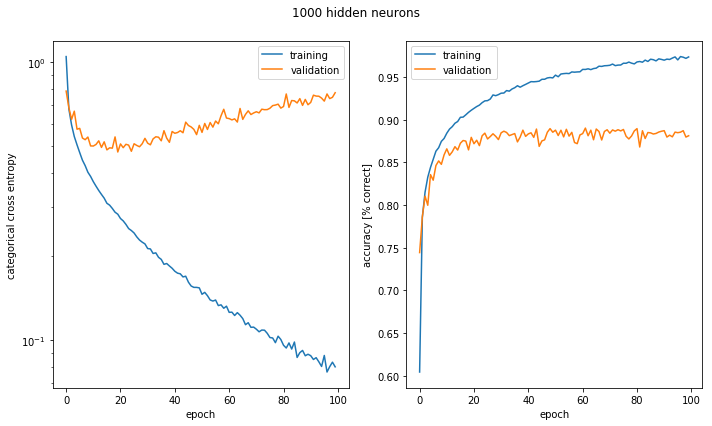

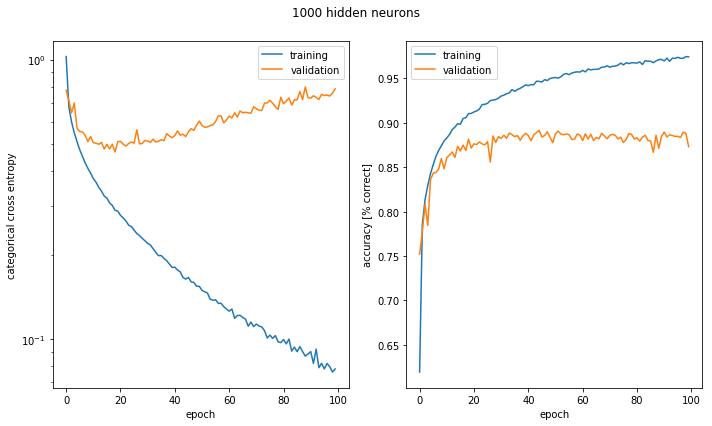

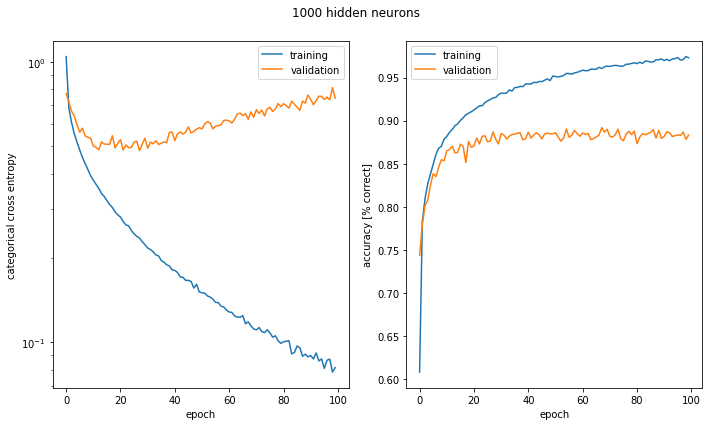

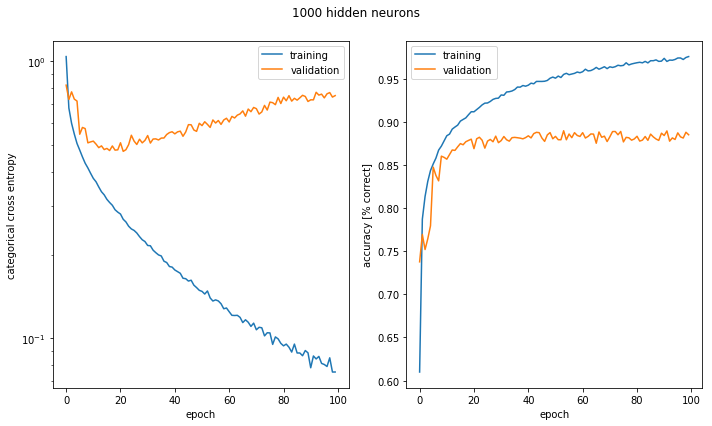

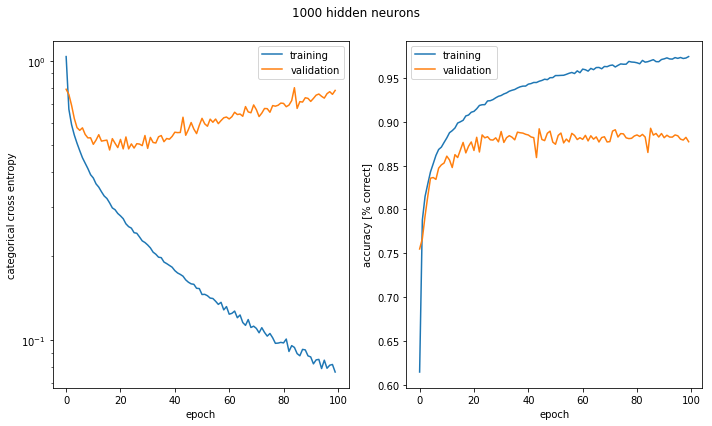

In [16]:
scores = []
for i in range(5):
    model = Sequential()
    model.add(Dense(1000, input_dim=256, activation='relu', name="H1"))
    model.add(Dense(5, activation='sigmoid', name = 'Y'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, verbose=1, validation_data=(x_test, y_test))
    scores.append(model.evaluate(x_test, y_test))
    plot_history(history, title="1000 hidden neurons")

In [17]:
accuracies.append([score[1] for score in scores])
losses.append([score[0] for score in scores])

In [18]:
print(accuracies)
print(losses)

[[0.7754565671742046, 0.7376507851134189, 0.7413572343350646, 0.7448615135389146, 0.6952624840149622], [0.8855044140762071, 0.8868522137931691, 0.8896152032129414, 0.8820675247216355, 0.8853022440423445], [0.8813262349536247, 0.8730372666179896, 0.8830109845395759, 0.8851000741611185, 0.8772828357264202]]
[[0.7924720719542029, 0.8855307615303802, 0.878995383096694, 0.873200718809776, 1.0164143992158006], [0.535830646831638, 0.5388244910255919, 0.5285938417676951, 0.5351720008738271, 0.5372383078962285], [0.7754966641855783, 0.7858728888369979, 0.7427113178789322, 0.7516195847785845, 0.7824193651873481]]


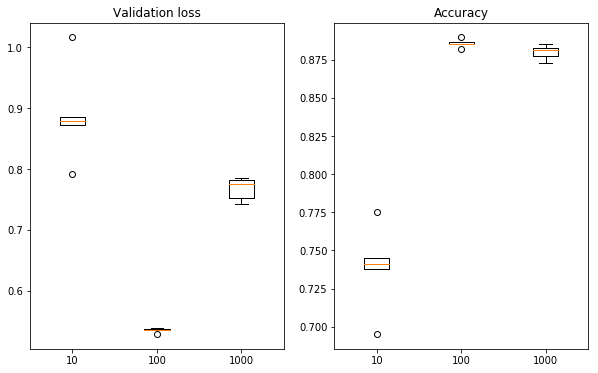

In [20]:
plt.figure()
ax = plt.subplot(121)
ax.set_title("Validation loss")
ax.boxplot(losses, labels=['10', '100', '1000'])
ax = plt.subplot(122)
ax.set_title("Accuracy")
ax.boxplot(accuracies, labels=['10', '100', '1000'])
plt.show()

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution